```{index} single: application; facility location
```
```{index} single: solver; cbc
```

# Facility location problem

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and HiGHS, then sets SOLVER to 
use the Highs solver via the appsi module. If run elsewhere, it assumes Pyomo and CBC
have been previously installed and sets SOLVER to use the CBC solver via the Pyomo 
SolverFactory. It then verifies that SOLVER is available.

In [1]:
import sys

if 'google.colab' in sys.modules:
    !pip install pyomo >/dev/null 2>/dev/null
    !pip install highspy >/dev/null 2>/dev/null

    from pyomo.contrib import appsi
    SOLVER = appsi.solvers.Highs(only_child_vars=False)
    
else:
    from pyomo.environ import SolverFactory
    SOLVER = SolverFactory('cbc')

assert SOLVER.available(), f"Solver {SOLVER} is not available."

## Problem description

Consider the problem of a supplier facing the task of fulfilling specific customer demands with minimal costs while simultaneously deciding how many facilities to build and where. In terms of data, we are given a set $I$ of customers, a set $J$ of possible locations, the cost $c_j$ of building facility $j$, and the cost $h_{ij}$ incurred to satisfy the demands of customer $i$ at facility $j$.

In this notebook we will formulate two equivalent models for this problem and compare their performance.

## First MILO formulation

Introduce two sets of binary variables,

$$
\begin{equation*}
    x_j:=
    \begin{cases}
    1 & \text{ if facility $j$ is built,}\\
    0 & \text{ otherwise,}
    \end{cases}
\end{equation*}
$$

and

$$
\begin{equation*}
    y_{ij}:=
    \begin{cases}
    1 & \text{ if customer $i$ is served at facility $j$,}\\
    0 & \text{ otherwise.}
    \end{cases}
\end{equation*}
$$

The resulting MILO is

$$
\begin{align*}
    \min \quad & \sum_{j \in J} c_j x_j + \sum_{i \in I} \sum_{j \in J} h_{ij} y_{ij} \\
    \textup{s.t.} \quad & \sum_{j \in J} y_{ij} =1 \qquad \forall \, i \in I & \textup{(every customer is served)}\\
    & y_{ij} \leq x_{j} \qquad \forall \, i\in I, \, \forall \, j \in J & \textup{(facility built before use)}\\
    & x_j \in \{0,1\} \qquad \forall \, i\in I\\
    & y_{ij} \in \{0,1\} \qquad \forall \, i\in I, \, \forall \, j \in J.
\end{align*}
$$

## Second MILO formulation

Let $n=|J|$ be the number of possible facility locations and $m=|I|$ the number of customers. Note that, since $\sum_j y_{ij} =1$ for every $i \in I$, we can replace the $n \times m$ constraints $y_{ij} \leq x_j$ by only $n$ constraints, namely

$$
\begin{equation*}
    \sum_i y_{ij} \leq n x_j \qquad \forall \, j \in J.
\end{equation*}
$$

The second MILO is

$$
\begin{align*}
    \min \quad & \sum_{j \in J} c_j x_j + \sum_{i \in I} \sum_{j \in J} h_{ij} y_{ij} \\
    \textup{s.t.} \quad & \sum_{j \in J} y_{ij} =1 \qquad \forall \, i \in I & \textup{(every customer is served)}\\
    & \sum_i y_{ij} \leq n x_j \qquad \forall \, j \in J & \textup{(facility built before use)}\\
    & x_j \in \{0,1\} \qquad \forall \, i\in I\\
    & y_{ij} \in \{0,1\} \qquad \forall \, i\in I, \, \forall \, j \in J.
\end{align*}
$$

This approach leads to a more concise mathematical formulation of the model. However, it may not be a good idea if we want to solve the problem using its linear relaxation. Indeed, by reducing the number of constraints, we inadvertently made the feasible region of the relaxation larger and less tight around the feasible integer points. This fact becomes clearly evident in the increased run-time required to solve the optimization problem when working with these weaker constraints, see figures below.

Instead of defining two separate Pyomo models, we will define a single common model and then add either the strong or weaker formulation of the "facility built before use" constraint.

In [2]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from time import perf_counter as pc
from tqdm.notebook import tqdm
import subprocess


def FacilityLocationCommon(installation, service):
    model = pyo.ConcreteModel("Facility location")
    model.facilities = pyo.Set(initialize=range(len(installation)))
    model.customers = pyo.Set(initialize=range(len(service)))

    model.x = pyo.Var(model.facilities, within=pyo.Binary)
    model.y = pyo.Var(model.customers, model.facilities, within=pyo.Binary)

    @model.Objective(sense=pyo.minimize)
    def obj(model):
        return sum([installation[j] * model.x[j] for j in model.facilities]) + sum(
            [
                service[i][j] * model.y[i, j]
                for i in model.customers
                for j in model.facilities
            ]
        )

    @model.Constraint(model.customers)
    def ChooseOneFacility(model, i):
        return sum([model.y[i, j] for j in model.facilities]) == 1

    return model


def FacilityLocationWeak(installation, service):
    model = FacilityLocationCommon(installation, service)

    @model.Constraint(model.facilities)
    def ServeIfOpen(model, j):
        return (
            sum([model.y[i, j] for i in model.customers])
            <= len(model.customers) * model.x[j]
        )

    return model


def FacilityLocationStrong(installation, service):
    model = FacilityLocationCommon(installation, service)

    @model.Constraint(model.customers, model.facilities)
    def ServeIfOpen(model, i, j):
        return model.y[i, j] <= model.x[j]

    return model


def GetSolution(model):
    X = [model.x[j]() > 0.5 for j in model.facilities]
    Y = [[model.y[i, j]() > 0.5 for j in model.facilities] for i in model.customers]
    return X, Y, model.obj()

We introduce functions to generate random instances for the problem and to then visualize the optimal solution.

In [3]:
def GenerateFacilityLocationInstance(nofFacilities, nofCustumers):
    facilities = range(nofFacilities)
    customers = range(nofCustumers)
    xC = np.random.randint(0, 100, nofCustumers)
    yC = np.random.randint(0, 100, nofCustumers)
    xF = np.random.randint(0, 100, nofFacilities)
    yF = np.random.randint(0, 100, nofFacilities)

    installation = np.random.randint(100, 200, nofFacilities)

    dist = lambda i, j: ((xC[i] - xF[j]) ** 2 + (yC[i] - yF[j]) ** 2)

    service = [[dist(i, j) for j in facilities] for i in customers]

    return installation, service, xC, yC, xF, yF


def ShowFacilityLocation(xC, yC, xF, yF, X=[], Y=[], title=None, model="weak"):
    [
        plt.plot([xC[i], xF[j]], [yC[i], yF[j]], "g-")
        for j in range(len(X))
        if X[j]
        for i in range(len(Y))
        if Y[i][j]
    ]
    plt.plot(xC, yC, "o")
    plt.plot(xF, yF, "s")
    if title:
        plt.title(f"Optimal value of the {model} formulation: {title}")
    plt.show()

We then generate an instance of the problem with 10 facilities and 100 customers and initialize both a strong and a weak Pyomo models.

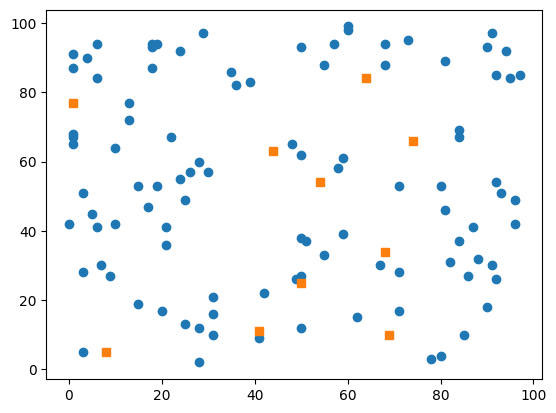

In [4]:
installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(10, 100)
ShowFacilityLocation(xC, yC, xF, yF)

weak = FacilityLocationWeak(installation, service)
strong = FacilityLocationStrong(installation, service)

CPU times: user 23.6 ms, sys: 8.77 ms, total: 32.3 ms
Wall time: 63.2 ms


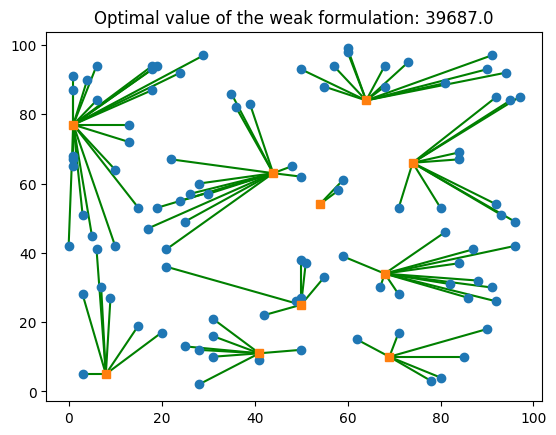

In [5]:
solver = 'cbc'
%time pyo.SolverFactory(solver).solve(weak)
ShowFacilityLocation( xC, yC, xF, yF, *GetSolution(weak) )

CPU times: user 42.6 ms, sys: 175 ms, total: 217 ms
Wall time: 61.7 ms


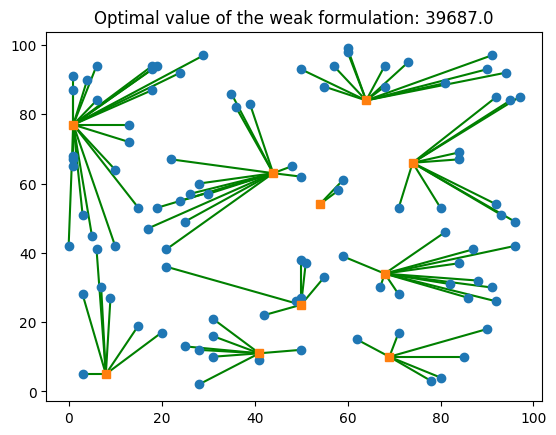

In [6]:
solver = 'cbc'
%time pyo.SolverFactory(solver).solve(strong)
ShowFacilityLocation( xC, yC, xF, yF, *GetSolution(strong) )

However, this is not a proper performance comparison between the two model formulations, since under the hood `cbc` is already solving the instance in a clever way. The commercial solver `gurobi` and the open-source solver `highs` also have a similar feature.

Weak formulation solved with gurobi_direct in 0.02282 seconds.


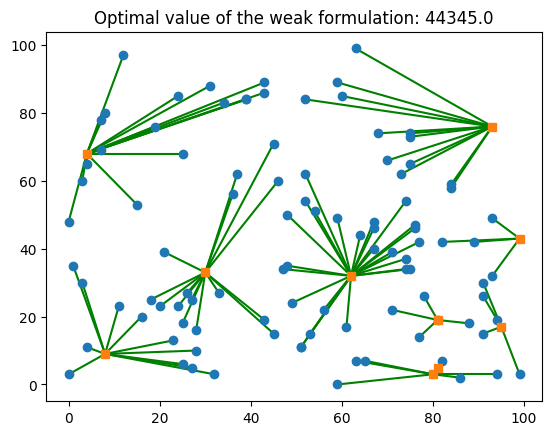

Strong formulation solved with gurobi_direct in 0.03380 seconds.


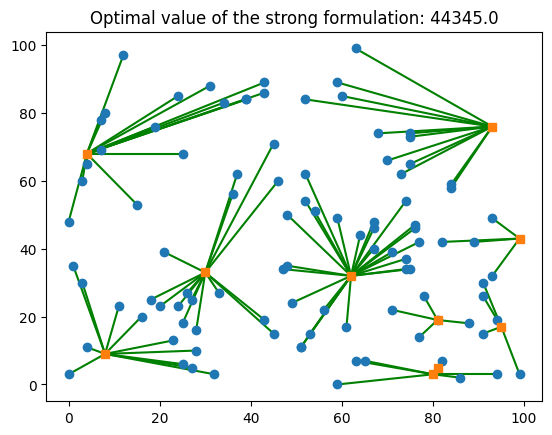

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Weak formulation solved with appsi_highs in 0.01791 seconds.


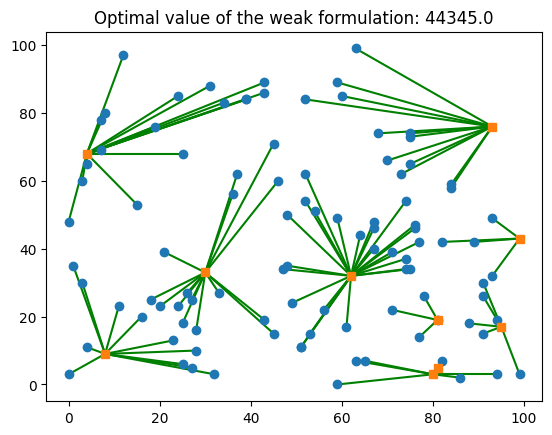

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Strong formulation solved with appsi_highs in 0.03075 seconds.


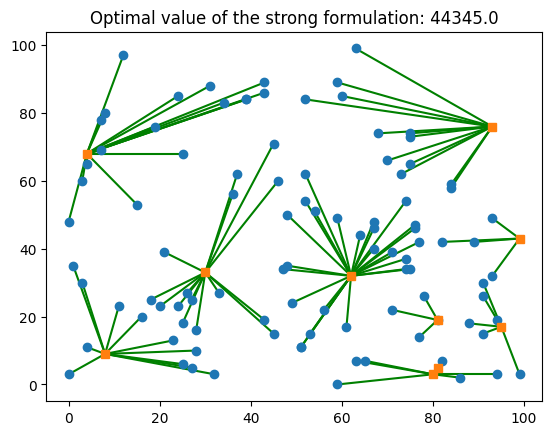

In [7]:
if 'google.colab' in sys.modules:
    !pip install gurobipy
    !pip install cplex
    !pip install xpress

import gurobipy
import highspy

installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(10, 100)
weak = FacilityLocationWeak(installation, service)
strong = FacilityLocationStrong(installation, service)

for solver in ["gurobi_direct", "appsi_highs"]:
    t = pc()
    pyo.SolverFactory(solver).solve(weak)
    t = pc() - t
    X, Y, value = GetSolution(weak)
    print(f"Weak formulation solved with {solver} in {t:5.5f} seconds.")
    ShowFacilityLocation(xC, yC, xF, yF, X, Y, f"{value:.1f}")
    t = pc()
    pyo.SolverFactory(solver).solve(strong)
    t = pc() - t
    X, Y, value = GetSolution(strong)
    print(f"Strong formulation solved with {solver} in {t:5.5f} seconds.")
    ShowFacilityLocation(xC, yC, xF, yF, X, Y, f"{value:.1f}", model="strong")

We now run a more extensive performance comparison considering increasingly larger instances of the problem. We will see that the strong formulation is consistently faster than the weak formulation.

In [8]:
def SolveInstances(dimensions, solvers, seed):
    np.random.seed(seed)
    model = {"weak": FacilityLocationWeak, "strong": FacilityLocationStrong}
    df = pd.DataFrame(
        index=dimensions,
        columns=[f"{s}_{m}" for s, m in it.product(solvers, model.keys())],
    )
    for n, m in tqdm(df.index):
        installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(n, m)
        instance = {
            option: model[option](installation, service) for option in model.keys()
        }
        values = []
        for column in tqdm(df.columns, leave=False):
            solver = column[: column.rfind("_")]
            option = column[column.rfind("_") + 1 :]
            t = pc()
            pyo.SolverFactory(solver).solve(instance[option])
            df.at[(n, m), column] = pc() - t
            _, _, v = GetSolution(instance[option])
            values.append(v)
        assert len(set(values)) == 1, values
    return df

We solve instances with 10 to 100 facilities and 100 to 1000 customers. We then plot the run-time of the strong and weak formulations as a function of the number of facilities.

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


<Axes: >

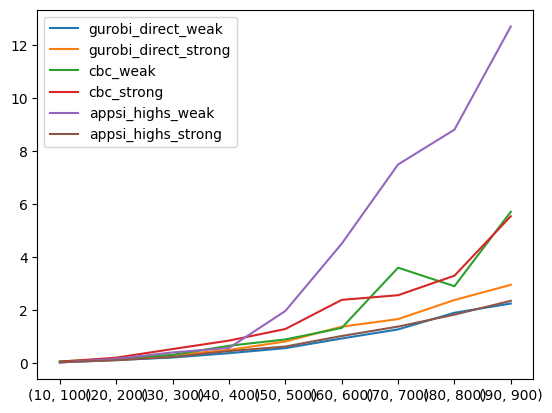

In [9]:
solvers = ["gurobi_direct", "cbc", "appsi_highs"]

SolveInstances([(n, 10 * n) for n in range(10, 100, 10)], solvers, 2023).plot()